# Práctica 1. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273)


# 0. Table of contents

- [Práctica 1. Aprendizaje Automático](#práctica-1-aprendizaje-automático)
  - [0. Table of contents](#0-table-of-contents)
  - [1. Requirements](#1-requirements)
  - [2. Reading the datasets](#2-reading-the-datasets)
  - [3. Exploratory Data Analysis](#3-EDA)

# 1. Requirements


In [ ]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy
import sklearn

from matplotlib.cbook import boxplot_stats as bps


### 1.1. Cleaning ../data/img/ folder
This way we avoid creating multiple images and sending the old ones to the trash.<br>
Also using this to upload cleaner commits to GitHub.


In [ ]:
""" Cleaning the ../data/img/ folder """
import os
import glob

files = glob.glob('../data/img/*')
for f in files:
    if os.path.isfile(f) and f.endswith('.png'):
        os.remove(f)

files = glob.glob('../data/img/box-plot/*')
for f in files:
    if os.path.isfile(f) and f.endswith('.png'):
        os.remove(f)


# 2. Reading the datasets

Reading the datasets from the bz2 files, group 2.


In [ ]:
""" Reading the dataset """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2",
                      compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2",
                      compression="bz2", index_col=0)


# 3. EDA


**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.0. Dataset preparation

To conduct exploratory data analysis (EDA) on our real data, we need to prepare the data first. Therefore, we have decided to separate the data into training and test sets at an early stage to avoid data leakage, which could result in an overly optimistic evaluation of the model, among other consequences. This separation will be done by dividing the data prematurely into training and test sets since potential data leakage can occur from the usage of the test partition, especially when including the result variable.

It is important to note that this step is necessary because all the information obtained in this section will be used to make decisions such as dimensionality reduction. Furthermore, this approach makes the evaluation more realistic and rigorous since the test set is not used until the end of the process.




In [ ]:
""" Train Test Split (time series) """

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(num_rows * 10/12)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[:num_train_rows, :]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[num_train_rows:, :] # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training (EDA): {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")


# ! We maintain the original dataframe for later use (as we will divide it into train and test dataframes below)
# ! For the EDA, we will use the train_df dataframe (with the outpout variable).

## 3.1. Dataset description

- **apcp_sfc**: 3-Hour accumulated precipitation at the surface (kg·m⁽⁻²⁾)
- **dlwrf_sfc**: Downward long-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **dswrf_sfc**: Downward short-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **pres_msl**: Air pressure at mean sea level (Pa)
- **pwat_eatm**: Precipitable Water over the entire depth of the atmosphere (kg·m⁽⁻²⁾)
- **spfh_2m**: Specific Humidity at 2 m above ground (kg·kg⁽⁻¹⁾)
- **tcdc_eatm**: Total cloud cover over the entire depth of the atmosphere (%)
- **tcolc_eatm**: Total column-integrated condensate over the entire atmos. (kg·m⁽⁻²⁾)
- **tmax_2m**: Maximum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmin_2m**: Mininmum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmp_2m**: Current temperature at 2 m above the ground (K)
- **tmp_sfc**: Temperature of the surface (K)
- **ulwrf_sfc**: Upward long-wave radiation at the surface (W·m⁽⁻²⁾)
- **ulwrf_tatm**: Upward long-wave radiation at the top of the atmosphere (W·m⁽⁻²⁾)
- **uswrf_sfc**: Upward short-wave radiation at the surface (W·m⁽⁻²⁾)


In [ ]:
# Display all the columns of the dataframe
pd.set_option('display.max_columns', None)

train_df.describe()


In [ ]:
train_df.shape


In [ ]:
train_df.head()


In [ ]:
train_df.info()


## 3.2. Missing values


Fist, we check the number the total number of missing values in the dataset in order to know if we have to clean the dataset or not.

In [ ]:
train_df.isna().sum()


As we can oberve, there are no missing values in the dataset, but theres still the possibility of having missing values measured as 0's, so we will check if all those zeros make sense in the context of the dataset or not.

In [ ]:
# In the plot, we can see that there are a lot of 0 values in the dataset
train_df.plot(legend=False, figsize=(15, 5))


In [ ]:
result = train_df.eq(0.0).sum()/len(train_df)*100

# Select those columns with more than 30% of zeros
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result


### Observations

As output of the previous cell, we can see that there exist a lot of zeros in the dataset, let's analize if those zeros make sense or not.

The variables with most ammount of zeros (>30%) are:

- **dswrf_s1_1**: Downward short-wave radiative flux average at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **uswrf_s1_1**: Upward short-wave radiation at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **apcp_s**: 3-Hour accumulated precipitation at the surface, as it is not raining every day, it is normal to have a lot of zeros
- **tcdc_ea**: Total cloud cover over the entire depth of the atmosphere, as it is not cloudy every day, it is normal to have a lot of zeros


First, lets start by assigning the zeros to NaNs. By doing this we can visualize the varibles that take more values other than zero.


In [ ]:
disp_df_nan = train_df.replace(0.0, np.nan)


In [ ]:
""" Plotting missing values """
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
# ? msno.bar is a simple visualization of nullity by column
msno.bar(disp_df_nan, labels=True, fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_bar.png")


In [ ]:
""" Plotting the missing values in a matrix """

# Fix ValueError: keyword grid_b is not recognized



# ? The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
msno.matrix(disp_df_nan)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_matrix.png")


In [ ]:
""" Plotting the missing values in a heatmap """
# As in a hetmap not every value is shown, we must delimit the values to the ones with more than 30% of missing values
result = disp_df.eq(0.0).sum()/len(disp_df)*100
result = result[result > 30.0] # Select those columns with more than 30% of zeros
result = result.sort_values(ascending=False)
result = result.index.tolist() # Convert to list
result

# ? The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
msno.heatmap(disp_df_nan[result], fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_heatmap.png")


In [ ]:
""" Plotting the dendrogram """

# ? The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:
msno.dendrogram(disp_df_nan, orientation="top",fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_dendrogram.png")


### Conclusions
In this section, we have observe that there are no attibutes with 'Null' nor 'NaN' nor 'None' values. This indicated that at a first glance, the data is clean, at least of those datatypes.

In second place, we have observed that the attributes that we suspected could have an important number of missing values (represented by 0 instead of the previously mentioned), had instead valuable information, as we have proved along this section.<br>Since the data is clean and we have concluded there are no missing values, we do not need to complete them using a model or other methods, so we can move on to the next step, observing the outliers.

## 3.3. Outliers


With the objective of noticing the outliers on each attribute, we create a box-plot of each of the attributes 

In [ ]:
list_of_attributes = train_df.columns.values.tolist()
#print(list_of_attributes)

In [ ]:
# Boxplot with all attributes in the dataset
# sns.boxplot(data=train_df, orient="h")
# plt.show()

In [ ]:
train_df.describe()

In [ ]:
train_df['apcp_sf1_1'].value_counts()

Here, by plotting the boxplots and making the outliers (fliers) visible, we are able to see some outliers in the dataset.<br>
Take into account that the outliers are represented by the points outside the boxplot and they can be potentially wrong values or just values that are not usual in the dataset (ruido).

In [ ]:
""" Plotting the boxplot for each attribute and getting the outliers of each attribute """
total_outliers = []
# * We iterate over the list of attributes
for attribute in list_of_attributes:
    # * sns.regplot(x=train_df[attribute], y=train_df['total'], fit_reg=False)
    sns.boxplot(data=train_df[attribute], x=train_df[attribute], orient="h")
    # * Use the command below to show each plot (small size for visualization sake)
    # sns.set(rc={'figure.figsize':(1,.5)})
    # plt.show()
    # * All the images are saved in the folder ../data/img/box-plot
    plt.savefig(f"../data/img/box-plot/{str(attribute)}.png")

    # We obtain the a list of outliers for each attribute
    list_of_outliers = train_df[attribute][train_df[attribute] > train_df[attribute].quantile(0.75) + 1.5*(train_df[attribute].quantile(0.75) - train_df[attribute].quantile(0.25))].tolist()
    outliers = [f'{attribute} outliers'] + [len(list_of_outliers)] + [list_of_outliers]
    # * In orde to print the total number of outliers for each attribute
    # print(f'{attribute} has {len(list_of_outliers)} outliers')
    # ! Data structure: [attribute, number of outliers, list of outliers]
    # print(outliers)
    total_outliers.append(outliers)

print(total_outliers)
print(len(total_outliers))

We managed to create a list containing the name of the atribute, the number of outliers and the value of the outliers for each attribute, calculated by applying the IQR method.<br> This is relevant as we managed to create a 'total_outliers' variable that contains the list data structures of all the different outliers from all the attributes, so that it can be easily accessed in a future to remove the outliers from the dataset if needed for testing purposes.

As suspected, we can see that there are a lot of outliers in the dataset, therefore it is plausible that some of them are noise, thus possibly being removed in a future model in order to improve it.<br>Now, we need to analyze if they are the result of bad measurements or if they are significant data for the analysis.


In [ ]:
""" Skewness """
# ? skewness: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
train_df.skew().sort_values(ascending=False)

In [ ]:
""" Kurtosis """
# ? kurtosis: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
train_df.kurt().sort_values(ascending=False)

In [ ]:
y = train_df['apcp_sf4_1']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=True, fit=st.lognorm)

In [ ]:
sns.distplot(train_df.skew(),color='blue',axlabel ='Skewness')

In [ ]:
plt.figure(figsize = (12,8))
sns.distplot(train_df.kurt(),color='r',axlabel ='Kurtosis',norm_hist= False, kde = True,rug = False)
#plt.hist(train.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='blue')
plt.show()

## 3.4. Correlation


In this section we are getting information about the correlation of the variables between them. This information is valuable in order to make good decisions when deleting redundant attributes. Also note we are getting information about the correlation between each attribute and the solution variable. This allows us to know the most relevant attributes, making the best decisions when creating the different models.  

In [ ]:
correlation = train_df.corr()
correlation = abs(correlation)
print(correlation.shape)  # 76 x 76 matrix of correlation values

### Getting the correlation matrix formatted into our own data structure
This is done for the sake of simplicity and to be able to visualize the correlation matrix in a more intuitive way.


In [ ]:
correlation_list = []

for column in train_df.columns:
    correlation.loc[:, column] = abs(correlation.iloc[:, train_df.columns.get_loc(column)])
    mask = correlation.loc[:, column] > 0.95
    # print(correlation[column][mask].sort_values(ascending = False))
    
    # Translate the comment below to English: 
    # we add the correlation values to a list of lists, which contains the names of the correlated columns and their correlation index
    
    # The first segment adds the name of the column we are analyzing
    # The second segment adds the names of the columns correlated (except the column we are analyzing) > 0.95
    # The third segment adds the correlation index of the columns correlated (except the column we are analyzing) > 0.95
    # Second and third segment are added to the first segment as a list of lists
    
    # First we need to create a dictionary with the column names and their correlation values (except the column we are analyzing)
    dict = ({key: value for key, value in correlation.loc[column, mask].sort_values(ascending = False).iloc[1:].to_dict().items()})
    # print (dict)
    
    # Then we create a list of lists with the column names and their correlation values from the dictionary created above
    corr_list = [[key] + [value] for key, value in dict.items()]
    # Finally we add the name of the column we are analyzing to the list of lists created above as the first element of the list (str)
    corr_list.insert(0, ["Columna: " + column])
    
    # ! Data structure: [[columna, [columna correlada 1, indice de correlacion], [columna correlada 2, indice de correlacion], ...], ...] 
    print(corr_list)
    
    correlation_list += [corr_list]
print(correlation_list)

### Correlation Heat Map

In [ ]:
""" seaborne Correlation Heat Map """
# It needs to show all the columns
fig, ax = plt.subplots(figsize=(19,18))

plt.title('Correlation Heat Map',y=1)
# We use blue color scale because it is easier to see the annotations and the correlation values
sns.heatmap(correlation, square=True, cmap='Blues', annot=True, fmt='.2f', annot_kws={'size': 4}, cbar_kws={"shrink": .5}, vmin=0.0, vmax=1)
# We can modify vmax=0.95 in order to get same color scale for values with more than 0.95 correlation
# Note: it delays around 15 seconds as it needs to plot a 76*76 matrix with its 5766 correlation values

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/correlation_heatmap.png", dpi=200)


Once obtained the most correlated columns of the dataset, we can plot them and visualize their correlation.

In [ ]:
# 1
columns = ['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1','apcp_sf4_1', 'apcp_sf5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 2
columns = [ 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 3
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 4
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 5
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1', 'uswrf_s1_1', 'uswrf_s2_1', 'uswrf_s3_1', 'uswrf_s4_1', 'uswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 6
columns = ['pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 7
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 8
columns = ['spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 9
# columns = ['tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1','tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

# sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
# plt.show()

In [ ]:
# 10
columns = ['ulwrf_t1_1', 'ulwrf_t2_1', 'ulwrf_t3_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 11
columns = ['ulwrf_t4_1', 'ulwrf_t5_1', ]

sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 12
columns = ['uswrf_s2_1', 'uswrf_s3_1', 'uswrf_s4_1', 'uswrf_s5_1']

sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


As we can observe in the graphs above, the most correlated variables present a linear relationship between them. This shows as a diagonal in the graph, since both variables grow at the same time. 

# 4. Train-Test division 

Since we are working with a time dependent data, we need to avoid mixing it. Also, we are required to add the first 10 years of data to the train set and the last 2 years to the test set. This means we are assigning a 83.333333 of the data to train and a 16.66666666 to test.

**Note**: This division was already done before the EDA. We overwrite it to start from a clean state.

Note: `iloc` is useful when we want to split data based on the index or other criteria, while `train_test_split` is useful when wanting to randomly split data into training and testing subsets.<br>
Therefore, we will use `iloc` to split the data into train and test sets as we are dealing with time dependent data.

In [58]:
""" Train Test Split (time series) """

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(num_rows * 10/12)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[:num_train_rows, :]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[num_train_rows:, :] # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training: {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")

# Print the dataframes
# print(train_df), print(test_df)

# * Separate the input features and target variable for training and testing
X_train = train_df.drop('salida', axis=1)   # This is the input features for training
y_train = train_df['salida']                # This is the target variable for training
X_test = test_df.drop('salida', axis=1)     # This is the input features for testing
y_test = test_df['salida']                  # This is the target variable for testing

# Print the shapes of the dataframes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Number of rows for training: 3650
Number of rows for testing: 730
(3650, 75) (3650,) (730, 75) (730,)


## 4.1. Train-Test RMSE and MAE function

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(10)

def train_and_test(model, X_train, y_train, X_test, y_test):
    model.fit(X=X_train,y=y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # RMSE
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    print(f"Results of the best estimator of {model.__class__.__name__}")
    print(f"RMSE train: {rmse_train:.2f}", f"RMSE test: {rmse_test:.2f}", sep='\t')
    print(f"MAE train: {mae_train:.2f}", f"MAE test: {mae_test:.2f}", sep='\t')
    
    plt.plot(X_train.iloc[:,[0]], y_train, '.', label='train')
    plt.plot(X_train.iloc[:,[0]], y_train_pred, 'r.', label='train pred')
    plt.legend()
    plt.show()
    
    return [rmse_train, rmse_test, mae_train, mae_test]

## 4.2. Print model results

In [60]:
def print_results(name, model, score, time):
    print("---------------------------------------------------")
    print(f"{name} best model is:\n\n{model}")
    print("\nParameters:", model.best_params_)
    print(f"\nPerformance: RMSE train: {score[0]}", f"RMSE test: {score[1]}", f"MAE train: {score[2]}", f"MAE test: {score[3]}", sep=' | ')
    print(f"Execution time: {time}s")
    

# 5. Basic methods:

We need to divide the train set using train-test-split in order to simulate the cross validation to get the best hiperparameters. test_size=0.1666666666

## 5.1. KNN


In [61]:
# Two dictionaries to store the results of the models
results, times = {}, {}

### 5.1.1. KNN - Predefined parameters
The KNN predefinded hyperparameters are the following: 

In [62]:
## Evaluation of the model

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import time

# TODO: separarlos según modelos

Results of the best estimator of Pipeline
RMSE train: 3037523.71	RMSE test: 3678927.44
MAE train: 2124772.88	MAE test: 2569264.68


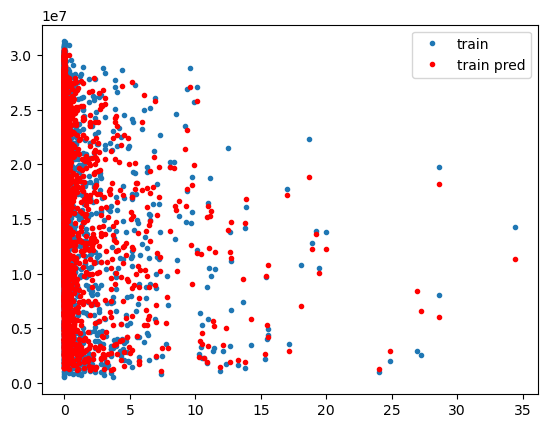

---------------------------------------------------
KNN PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7f3db50f1ea0>)),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__metric': ['minkowski'],
                         'model__n_neighbors': [5],
                         'model__weights': ['uniform']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}

Performance: RMSE train: 3037523.710057112 | RMSE test: 3678927.4363231137 | MAE train: 2124772.882191781 | MAE test: 2569264.684931507
Execution time: 0.11408281326293945s


In [63]:
np.random.seed(10)

# Using a pipeline to scale the data and then apply the model
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', KNeighborsRegressor())
])

param_grid = {
    'model__n_neighbors': [5],
    'model__weights': ['uniform'],
    'model__metric': ['minkowski']
}

regr = GridSearchCV(pipeline, 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=TimeSeriesSplit(n_splits=5),  # We use TimeSeriesSplit to split the data in folds without losing the temporal order
                        )

start_time = time.time()
regr.fit(X=X_train,y=y_train)
end_time = time.time()
total_time = end_time - start_time

score = train_and_test(regr.best_estimator_, X_train, y_train, X_test, y_test) # We train and test the model another time to get the final score (with the best parameters)

results['KNN_pred'] = score
times['KNN_pred'] = total_time

print_results("KNN PREDEFINED PARAMETERS", regr, score, total_time)

###  5.1.2. KNN - Selected parameters

Results of the best estimator of Pipeline
RMSE train: 1.51	RMSE test: 3473652.84
MAE train: 0.59	MAE test: 2431229.63


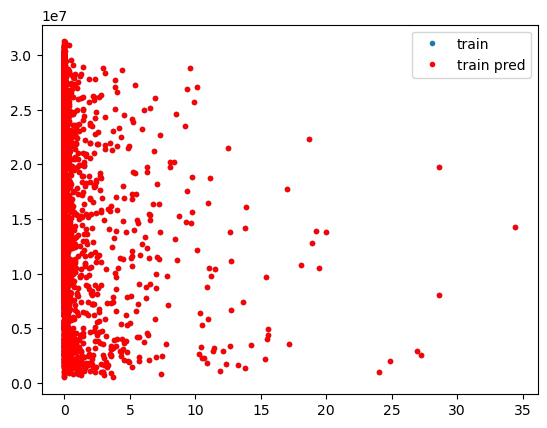

---------------------------------------------------
KNN SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('select',
                                              SelectKBest(score_func=<function f_regression at 0x7f3db50f1ea0>)),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=20,
                   param_distributions={'model__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski',
                                                          'chebyshev'],
                                        'model__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
           

In [64]:
np.random.seed(10)
budget = 20

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('select', SelectKBest(f_regression)),
    ('model', KNeighborsRegressor())
])

param_grid = {'model__n_neighbors': list(range(1, 20)),
              'model__weights': ['uniform', 'distance'],
              'model__metric': ['euclidean', 'manhattan', 'minkowski','chebyshev'],
              'select__k': list(range(1, X_train.shape[1]+1))
              }

regr = RandomizedSearchCV(pipeline, 
                         param_grid,
                         scoring='neg_mean_absolute_error', 
                         cv=TimeSeriesSplit(n_splits=5), # TimeSeriesSplit to split the data in folds without losing the temporal order
                         n_iter=budget
                        )

start_time = time.time()
regr.fit(X=X_train,y=y_train)
end_time = time.time()
total_time = end_time - start_time

score = train_and_test(regr.best_estimator_, X_train, y_train, X_test, y_test) # We train and test the model another time to get the final score (with the best parameters)

results['KNN_select'] = score
times['KNN_select'] = total_time

print_results("KNN SELECTED PARAMETERS", regr, score, total_time)

## 5.2 Regression Trees

### 5.2.1. Regression Trees - Predefined parameters

-3415756.7763157897
Results of the best estimator of Pipeline
RMSE train: 0.00	RMSE test: 4413372.50
MAE train: 0.00	MAE test: 3136761.37


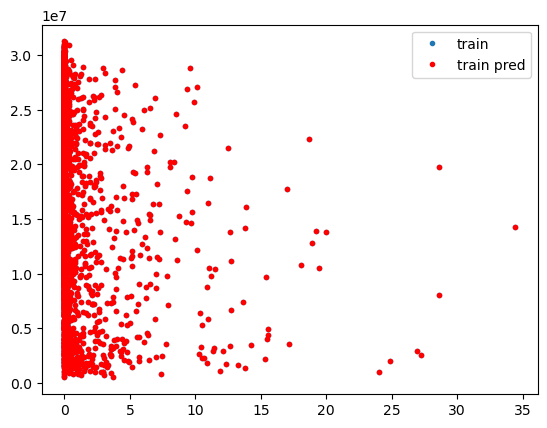

---------------------------------------------------
REGRESSION TREES PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', DecisionTreeRegressor())]),
             param_grid={'model__criterion': ['squared_error'],
                         'model__min_samples_split': [2],
                         'model__splitter': ['best']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__criterion': 'squared_error', 'model__min_samples_split': 2, 'model__splitter': 'best'}

Performance: RMSE train: 0.0 | RMSE test: 4413372.497795917 | MAE train: 0.0 | MAE test: 3136761.3698630137
Execution time: 0.9846105575561523s


In [65]:
np.random.seed(10)

pipeline = Pipeline([
    ('model', DecisionTreeRegressor())
])

param_grid = {'model__criterion' : ["squared_error"],
              'model__splitter' : ["best"],              
              'model__min_samples_split' : [2]}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
regr = GridSearchCV(     pipeline, 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=TimeSeriesSplit(n_splits=5), 
                        )

start_time = time.time()
regr.fit(X=X_train,y=y_train)
print(regr.best_score_)
end_time = time.time()
total_time = end_time - start_time

score = train_and_test(regr.best_estimator_, X_train, y_train, X_test, y_test) # We train and test the model another time to get the final score (with the best parameters)

results['RegTrees_pred'] = score
times['RegTrees_pred'] = total_time

print_results("REGRESSION TREES PREDEFINED PARAMETERS", regr, score, total_time)

### 5.2.2. Regression Trees - Selected parameters

Results of the best estimator of Pipeline
RMSE train: 3822940.21	RMSE test: 4026300.83
MAE train: 2519139.21	MAE test: 2703236.71


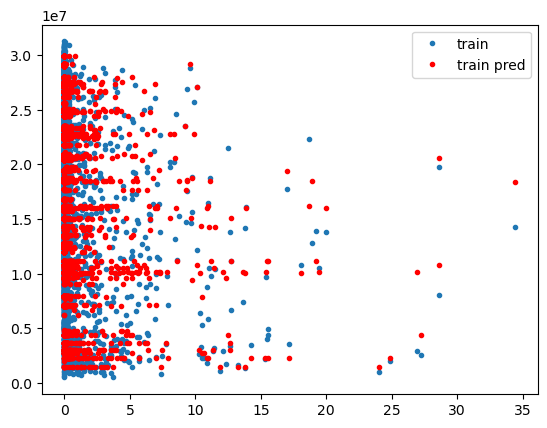

---------------------------------------------------
REGRESSION TREES SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(score_func=<function f_regression at 0x7f3db50f1ea0>)),
                                             ('model',
                                              DecisionTreeRegressor())]),
                   n_iter=15,
                   param_distributions={'model__criterion': ['absolute_error',
                                                             'squared_error'],
                                        'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9,...
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...

In [66]:
np.random.seed(10)
budget = 15

pipeline = Pipeline([
    ('select', SelectKBest(f_regression)),
    ('model', DecisionTreeRegressor())
])

param_grid = {'model__criterion' : ["absolute_error", "squared_error"],
              'model__splitter' : ["best", "random"],
              'model__max_depth' : list(range(1, 35)),
              'model__min_samples_split' : list(range(5, 200)),
              'model__max_features' : ["sqrt", "log2", None],
              'select__k': list(range(1, X_train.shape[1]+1))}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
regr = RandomizedSearchCV(pipeline, 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=TimeSeriesSplit(n_splits=5),
                         n_iter=budget
)

start_time = time.time()                      
regr.fit(X=X_train,y=y_train)
end_time = time.time()
total_time = end_time - start_time

score = train_and_test(regr.best_estimator_, X_train, y_train, X_test, y_test) # We train and test the model another time to get the final score (with the best parameters)

results['RegTrees_select'] = score
times['RegTrees_select'] = total_time

print_results("REGRESSION TREES SELECTED PARAMETERS", regr, score, total_time)


## 5.3 Linnear regression

### 5.3.1. Linear regression - Predefined parameters

Results of the best estimator of Pipeline
RMSE train: 3256574.00	RMSE test: 3107801.96
MAE train: 2323171.61	MAE test: 2248616.81


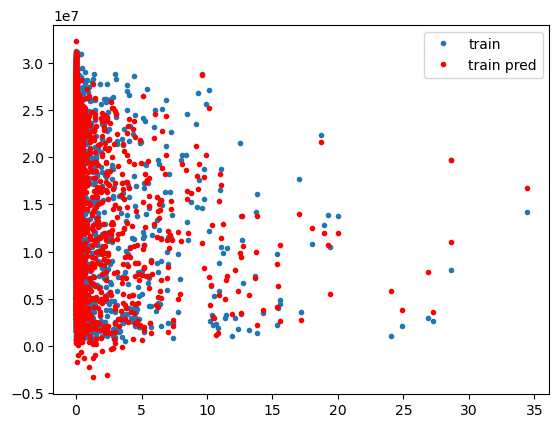

---------------------------------------------------
LINEAR REGRESSION PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7f3db50f1ea0>)),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__fit_intercept': True, 'select__k': 72}

Performance: RMSE train: 3256573.9989301027 | RMSE test: 3107801.957650574 | MAE train: 2323171.609251

In [72]:
np.random.seed(10)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', LinearRegression())
])

param_grid = {'model__fit_intercept': [True],
              'select__k': list(range(1, X_train.shape[1]+1))}  # TODO: ns puede tener el pred. params. el select_k -> muy lento y no se si lo debe tener

regr = GridSearchCV(pipeline,
                    param_grid,
                    scoring='neg_mean_absolute_error',
                    cv=TimeSeriesSplit(n_splits=5)
                    )


start_time = time.time()
regr.fit(X=X_train, y=y_train)
end_time = time.time()
total_time = end_time - start_time

score = train_and_test(regr.best_estimator_, X_train, y_train, X_test, y_test) # We train and test the model another time to get the final score (with the best parameters)

results['LinearReg_pred'] = score
times['LinearReg_pred'] = total_time

print_results("LINEAR REGRESSION PREDEFINED PARAMETERS", regr, score, total_time)


### 5.3.2. Linear regression - Selected parameters

Model: -2878304.102152183
Results of the best estimator of Pipeline
RMSE train: 3896969.09	RMSE test: 3769265.61
MAE train: 2892278.05	MAE test: 2801572.42


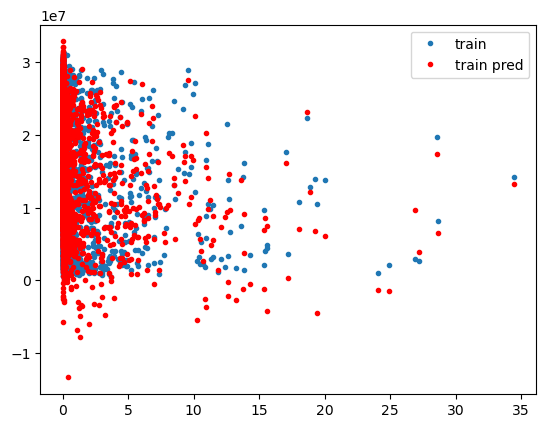

Model: -2409149.2610517377
Results of the best estimator of Pipeline
RMSE train: 3257805.20	RMSE test: 3095921.14
MAE train: 2320591.77	MAE test: 2234624.56


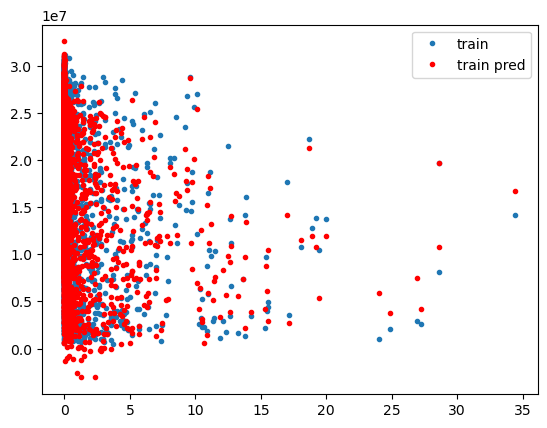

Model: -2760398.894261714
Results of the best estimator of Pipeline
RMSE train: 3744907.67	RMSE test: 3602906.11
MAE train: 2790907.85	MAE test: 2606869.29


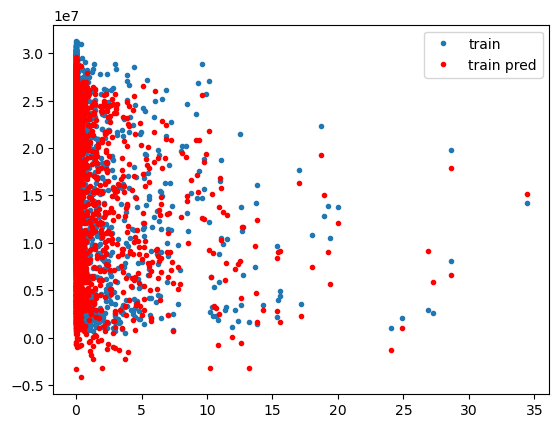

{'KNN_pred': [3037523.710057112, 3678927.4363231137, 2124772.882191781, 2569264.684931507], 'KNN_select': [1.5094925774601902, 3473652.8410133934, 0.5892264539107668, 2431229.6270175204], 'RegTrees_pred': [0.0, 4413372.497795917, 0.0, 3136761.3698630137], 'RegTrees_select': [3822940.2144440734, 4026300.8251481955, 2519139.205479452, 2703236.712328767], 'LinearReg_pred': [3256573.9989301027, 3107801.957650574, 2323171.609251118, 2248616.80671808], 'LinearReg_select': [3257805.1961352024, 3095921.136409502, 2320591.76837326, 2234624.5584775107]}
{'KNN_pred': 0.11408281326293945, 'KNN_select': 2.4589850902557373, 'RegTrees_pred': 0.9846105575561523, 'RegTrees_select': 9.628760576248169, 'LinearReg_pred': 3.8579213619232178, 'LinearReg_select': 2.0310802459716797}
---------------------------------------------------
LINEAR REGRESSION SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator

In [68]:
np.random.seed(10)
budget = 10
n_splits = 5

all_scores = []

# ! Pipelines
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', Lasso(fit_intercept=True, tol=.5, random_state=10))
])

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', Ridge(fit_intercept=True, tol=.5, random_state=10))
])

pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', ElasticNet(fit_intercept=True, tol=.5, random_state=10))
])

# ! Parameter grids
param_grid_lasso = {'model__alpha': np.logspace(-2, 1, 30),
              'select__k': list(range(1, X_train.shape[1]+1))}

pram_grid_ridge = {'model__alpha': np.logspace(-2, 1, 30),
              'select__k': list(range(1, X_train.shape[1]+1))}

param_grid_elastic = {'model__alpha': np.logspace(-2, 1, 30),
                'model__l1_ratio': np.linspace(0, 1, 30),
                'select__k': list(range(1, X_train.shape[1]+1))}

# ! If we want to use random values for the parameters -> unconsistency in the results
regr_lasso = RandomizedSearchCV(pipeline_lasso,
                                param_grid_lasso,
                                scoring='neg_mean_absolute_error',
                                cv=TimeSeriesSplit(),
                                n_iter=budget,
                                )

regr_ridge = RandomizedSearchCV(pipeline_ridge,
                                pram_grid_ridge,
                                scoring='neg_mean_absolute_error',
                                cv=TimeSeriesSplit(),
                                n_iter=budget,
                                )

regr_elastic = RandomizedSearchCV(pipeline_elastic,
                                  param_grid_elastic,
                                  scoring='neg_mean_absolute_error',
                                  cv=TimeSeriesSplit(),
                                  n_iter=budget,
                                  )

regr = [regr_lasso, regr_ridge, regr_elastic]

start_time = time.time()
for i in regr:
    i.fit(X=X_train,y=y_train)
    print(f"Model: {i.best_score_}")
    # Now we reevaluate the model on the test set to obtain more accurate results
    all_scores.append(train_and_test(i.best_estimator_, X_train, y_train, X_test, y_test))
    
end_time = time.time()

# Select the best model (based on the MAE)
max_score = min(all_scores, key=lambda x: x[3])  # Best model is the one that minimizes the MAE
best_regr = regr[all_scores.index(max_score)]
total_time = end_time - start_time
 
results['LinearReg_select'] = max_score
print(results)
times['LinearReg_select'] = total_time
print(times)

print_results("LINEAR REGRESSION SELECTED PARAMETERS", best_regr, max_score, total_time)

# TODO: arreglar tiempos, equilibrar todos los paramaetros


## 5.4. Results

In [69]:
np.random.seed(10)

# ! Obtain best, worst, fastest and slowest model
max_score = max(results.values(), key=lambda x: x[3])  # We determine the best model based on the MAE obtained in the test set (thus, excluding overfitting)
min_score = min(results.values(), key=lambda x: x[3])
# Obtain the key name of the best and worst model
max_time = max(times.values(), key=lambda x: x)
min_time = min(times.values(), key=lambda x: x)

best_model = list(results.keys())[list(results.values()).index(min_score)]
worst_model = list(results.keys())[list(results.values()).index(max_score)]
fastest_model = list(times.keys())[list(times.values()).index(min_time)]
slowest_model = list(times.keys())[list(times.values()).index(max_time)]

print(f"Best model: {best_model} with score {min_score} and time {list(times.values())[list(results.values()).index(min_score)]}s")
print(f"Worst model: {worst_model} with score {max_score} and time {list(times.values())[list(results.values()).index(max_score)]}s")
print(f"Fastest model: {fastest_model} with score {list(results.values())[list(times.values()).index(min_time)]} and time {min_time}s")
print(f"Slowest model: {slowest_model} with score {list(results.values())[list(times.values()).index(max_time)]} and time {max_time}s")


# ! Average (test MAE) score of the models
# TODO: arreglar!!!
# avg_score = 0
# avg_time = 0
# 
# for key, values in results:
    # avg_score += results[key][3]
    # avg_time += times[key]
# 
# print(f"\nAverage score: {abs(avg_score/len(results))}")
# print(f"Average time: {avg_time/len(times)}\n")


# ! Differences
print("The score difference between the best and worst model is: ", abs(max_score[3] - min_score)[3])  # test MAE
print("The score difference between the best and fastest model is: ", abs(min_score[3] - list(results.values())[list(times.values()).index(min_time)])[3])  # test MAE
print("The time difference between the best and fastest model model is: ", abs(list(times.values())[list(results.values()).index(min_score)] - min_time))
print("The time difference between the fastest and slowest model is: ", abs(max_time - min_time))

Best model: LinearReg_select with score [3257805.1961352024, 3095921.136409502, 2320591.76837326, 2234624.5584775107] and time 2.0310802459716797s
Worst model: RegTrees_pred with score [0.0, 4413372.497795917, 0.0, 3136761.3698630137] and time 0.9846105575561523s
Fastest model: KNN_pred with score [3037523.710057112, 3678927.4363231137, 2124772.882191781, 2569264.684931507] and time 0.11408281326293945s
Slowest model: RegTrees_select with score [3822940.2144440734, 4026300.8251481955, 2519139.205479452, 2703236.712328767] and time 9.628760576248169s
The score difference between the best and worst model is:  902136.811385503
The score difference between the best and fastest model is:  334640.12645399617
The time difference between the best and fastest model model is:  1.9169974327087402
The time difference between the fastest and slowest model is:  9.51467776298523


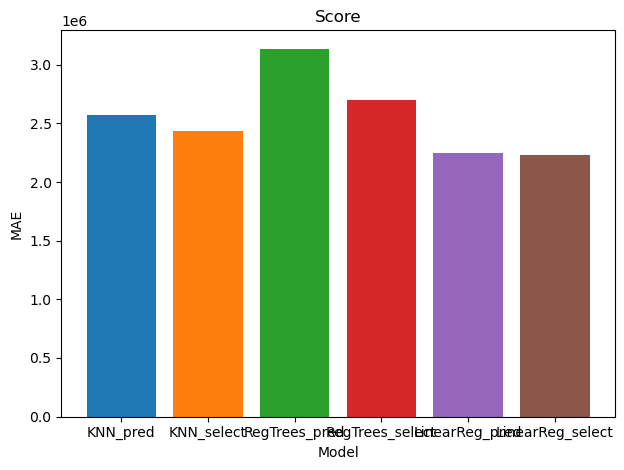

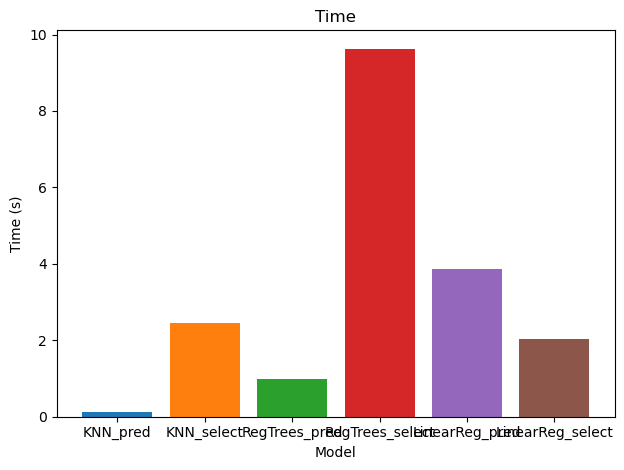

In [70]:
# ! Plot the score
for key, value in results.items():
    plt.bar(key, abs(value[3]))
plt.title('Score')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.tight_layout()

# Exporting image as png to ../data/img folder 
plt.savefig("../data/img/basic_methods_score.png")
plt.show()

# ! Plot the time
for key, value in times.items():
    plt.bar(key, value)
plt.title('Time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.tight_layout()

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

## 5.5. Conclusions: 

After computig the models we can see that the best model in terms of MAE is the LinearReg_selected, but the best timing model is LinearReg_pred.

***Obtener algunas conclusiones, tales como: ¿cuál es el mejor método? ¿Cuál de los métodos 
básicos de aprendizaje automático es más rápido? ¿Los resultados son mejores que los 
regresores triviales/naive/baseline? ¿El ajuste de hiperparámetros mejora con respecto a los 
valores por omisión? ¿Hay algún equilibrio entre tiempo de ejecución y mejora de 
resultados? Etc***



# 6. Reducing Dimensionality
>¿Es posible reducir la dimensionalidad del problema?

Yes, it is possible to reduce the problem dimensionality, and as stated throughout the EDA, there are a lot of attributes that are highly correlated, so we can reduce the dimensionality of the problem by removing some of the attributes. Thus, it is recommended to use a PCA to reduce the dimensionality of the problem.

# X. Output the Jupyter Notebook as an HTML file

In [71]:
import os

# Export the notebook to HTML
os.system('jupyter nbconvert --to html model.ipynb --output ../data/html/model.html')
print("Notebook exported to HTML")


[NbConvertApp] Converting notebook model.ipynb to html


Notebook exported to HTML


[NbConvertApp] Writing 751487 bytes to ../data/html/model.html
